In [240]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from PIL import Image
from skimage.transform import (radon, iradon)
from scipy.spatial.transform import Rotation as R
from os.path import isdir
import os

import imageio.v2 as imageio

import time
import utils
import astra

import algotom.io.loadersaver as losa
import algotom.io.converter as cvr
import algotom.prep.correction as corr
import algotom.prep.calculation as calc
import algotom.prep.removal as remo
import algotom.prep.filtering as filt
import algotom.rec.reconstruction as rec

In [17]:
# astra.test()

ASTRA Toolbox v2.1.2
Getting GPU info... GPU #0: NVIDIA GeForce RTX 3060 Laptop GPU, with 6143MB
Testing basic CPU 2D functionality... Ok
Testing basic CUDA 2D functionality... Ok
Testing basic CUDA 3D functionality... Ok


In [184]:
# Import sinogram from previous calculations

sinogram_900 = np.array(Image.open(r"sinograms\sinogram_900.tif"))
n_imgs, width = sinogram_900.shape
print(f"n_imgs = {n_imgs}, width = {width}")

angles = np.linspace(0, 2*np.pi, n_imgs, endpoint=False)

# fig, ax = plt.subplots(figsize=(6,3), dpi=200)
# ax.imshow(sinogram_900, cmap=plt.cm.Greys_r, interpolation='nearest', aspect='auto')
# plt.show()

n_imgs = 1800, width = 4032


In [185]:
def ct_scale(projections):
    projections = projections - 57000
    projections[projections>0.0] = 0.0
    projections = projections/np.max(np.abs(projections))
    return np.abs(projections)

In [186]:
# Cone-beam CT settings, extracted from metadata

distance_source_origin = 95.73050  # mm
distance_camera_source = 172.31482 # mm
distance_origin_detector = distance_camera_source - distance_source_origin # mm

ar0slice = np.array(Image.open(r"data_5um\17_01_2024_P2_B2_CONTROL_ar0.tif"))
detector_rows, detector_cols = ar0slice.shape

detector_pixel_size = 5e-3 # mm

num_of_projections = 1800

angles = np.deg2rad(np.arange(0, 360.0, step=0.2))

In [226]:
# Load hdf object with all projections
proj_obj = losa.load_hdf(r'.\data_5um\5um_data.hdf', "entry/projections")
(depth, height, width) = proj_obj.shape
print(f"depth = {depth}")
print(f"height = {height}")
print(f"width = {width}")

# Reconstruct slices around the center
# id_init = 1200
# ids = [0, depth//2, depth-1]
ids = np.arange(depth//2-10,depth//2+10) # middle slice is id=10


# projections = np.zeros((20, num_of_projections, detector_cols), dtype=float)
projections = np.zeros((len(ids), num_of_projections, detector_cols), dtype=np.float64)

# Extract projections from 10 slices below and above the middle slice
for i in range(num_of_projections):
    # projections[:, i, :] = proj_obj[i, id_init:id_init + 20, :]
    projections[:, i, :] = proj_obj[i, ids, :]

projections = ct_scale(projections)
print(projections.dtype)

depth = 1800
height = 2688
width = 4032
float64


In [227]:
projections.shape

(20, 1800, 4032)

1.0
0.0


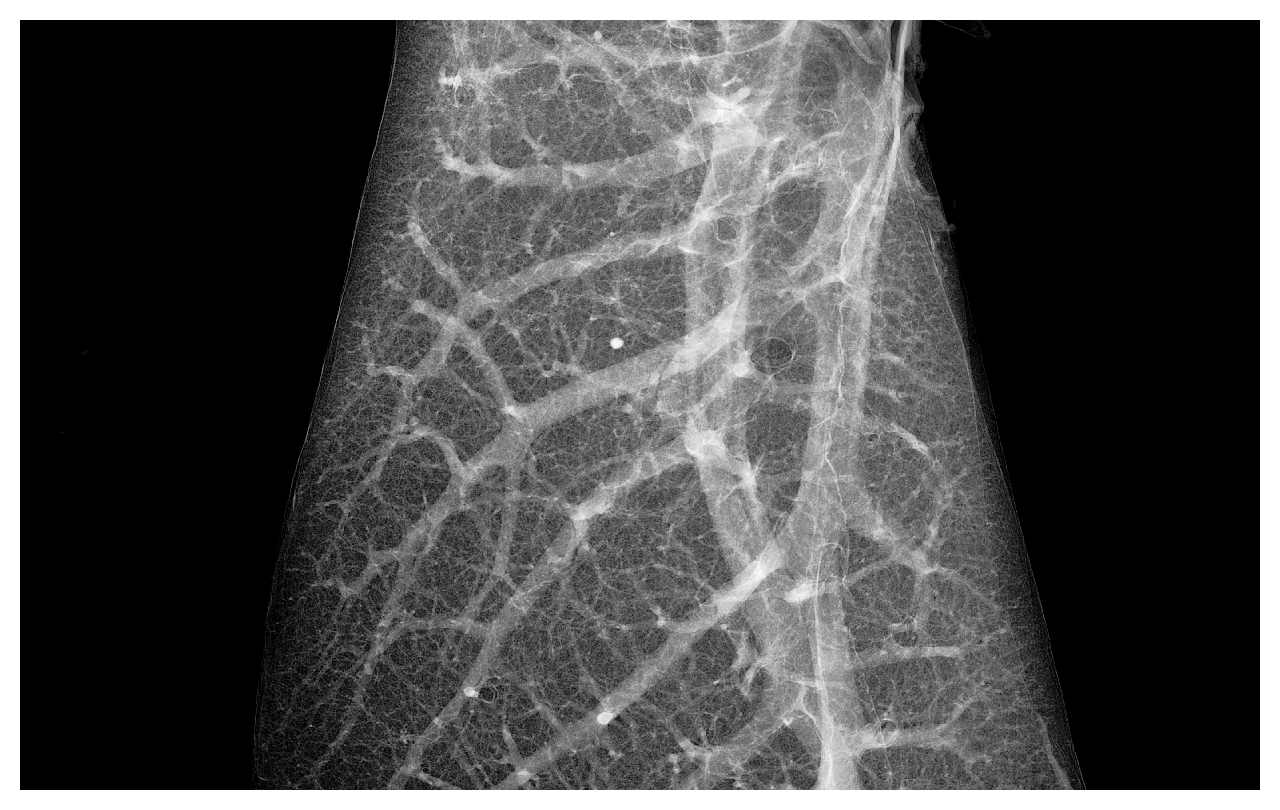

0.0
0.0


In [246]:
# metrics

first_projection = proj_obj[0,:,:]
first_projection = ct_scale(first_projection)

print(np.max(first_projection))
print(np.min(first_projection))

fig, ax = plt.subplots(figsize=(8,5), dpi=200)
ax.imshow(first_projection, cmap=plt.cm.Greys_r, interpolation='nearest', aspect='auto', vmin=0, vmax=1)
ax.axis('off')
plt.show()

first_projection[:10,:10]
print(np.max(first_projection[:100,:100]))
print(np.min(first_projection[:100,:100]))

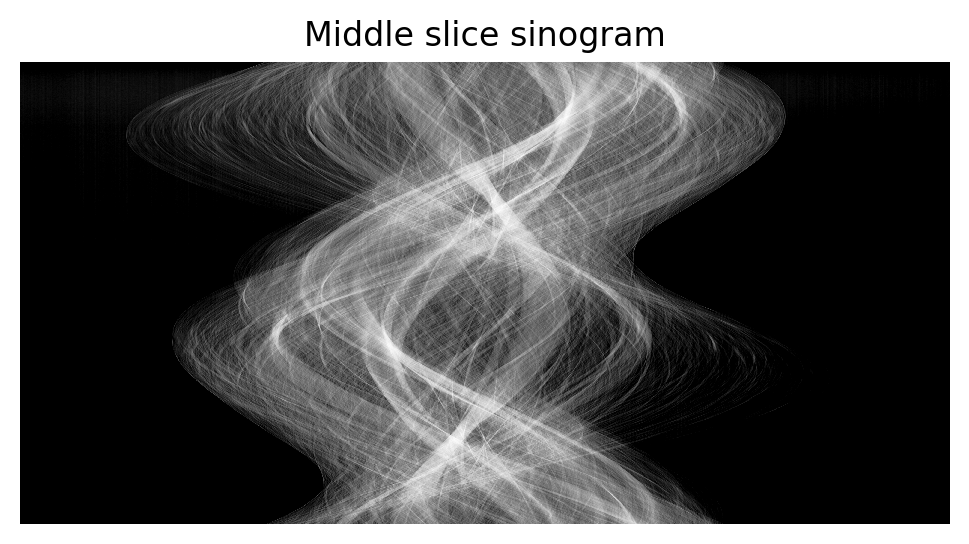

0.9968074260878896
0.0


In [248]:
# Middle slice

fig, ax = plt.subplots(figsize=(6,3),dpi=200)
ax.imshow(projections[10, :, :], cmap=plt.cm.Greys_r, interpolation='nearest', aspect='auto')
ax.set_title("Middle slice sinogram")
ax.axis('off')
plt.show()

print(np.max(projections[10, :, :]))
print(np.min(projections[10, :, :]))

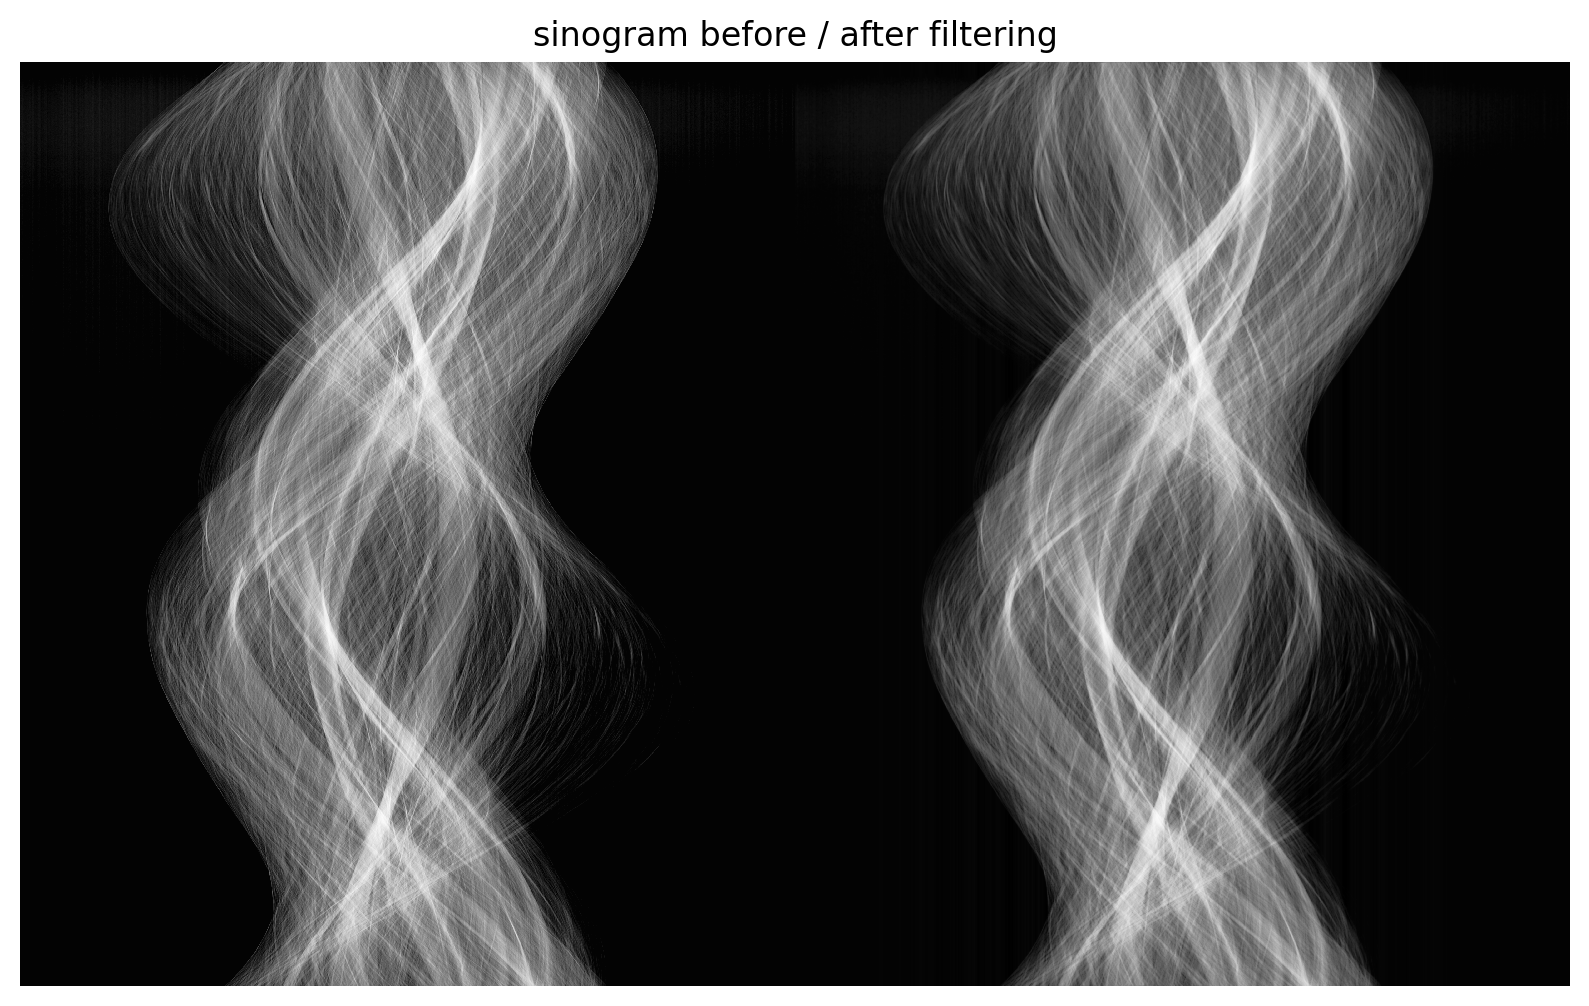

0.9974244781885496
0.0


In [249]:
fig, ax = plt.subplots(figsize=(10,6),dpi=200)

sinogram_mid_orig = projections[10, :, :]

sinogram_mid = remo.remove_zinger(sinogram_mid_orig, 0.08)
sinogram_mid = remo.remove_stripe_based_normalization(sinogram_mid, 50)
sinogram_mid = filt.fresnel_filter(sinogram_mid, 100, apply_log=False)

ax.imshow(np.hstack((sinogram_mid_orig, sinogram_mid)), cmap=plt.cm.Greys_r, interpolation='nearest', aspect='auto')
ax.axis('off')
ax.set_title("sinogram before / after filtering")
plt.show()

print(np.max(projections[0, :, :]))
print(np.min(projections[0, :, :]))

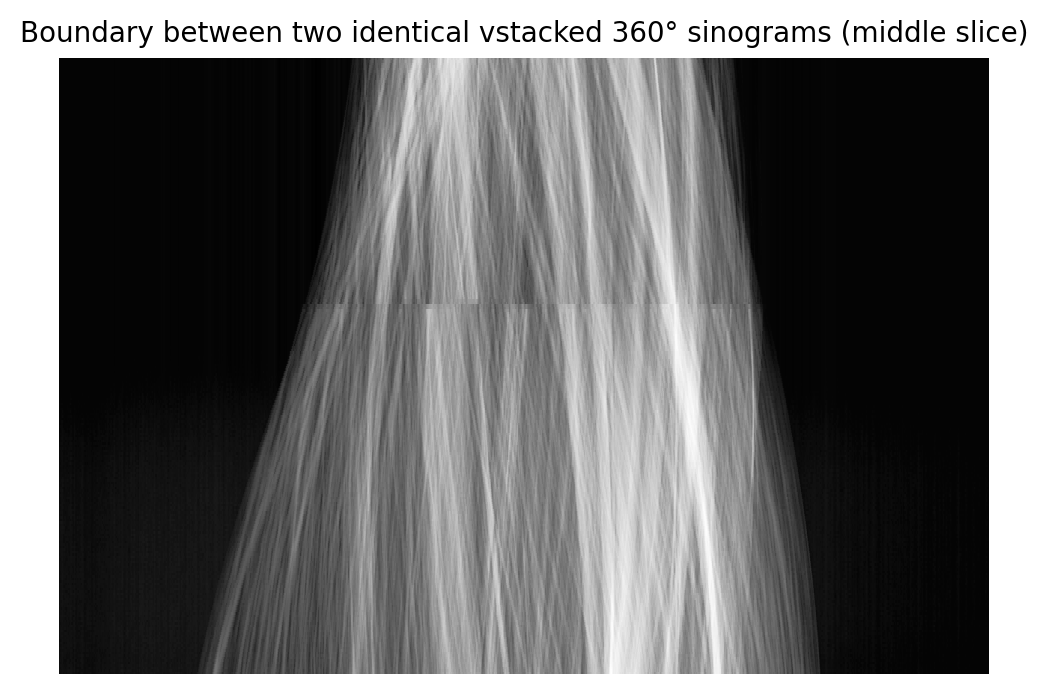

In [253]:
# casi

def shift(proj, cor):
    return np.roll(proj, cor, axis=1)

fig, ax = plt.subplots(figsize=(6,4),dpi=200)

cor = 0
shifted_sinogram_mid = shift(sinogram_mid, cor) # shifting does not help

ax.imshow(np.vstack((shifted_sinogram_mid[0:,:], shifted_sinogram_mid[0:,:]))[1700:1950,:], cmap=plt.cm.Greys_r, interpolation='nearest', aspect='auto')
ax.set_title("Boundary between two identical vstacked 360° sinograms (middle slice)", size=10)
ax.axis('off')
plt.show()

In [235]:
# Projection geometry for cone-beam CT reconstruction

proj_geom = astra.create_proj_geom('cone', 1, 1, len(ids), detector_cols, angles,
                         (distance_source_origin + distance_origin_detector)/detector_pixel_size, 0)
projections_id = astra.data3d.create('-sino', proj_geom, projections)

In [255]:
# Normalized geometry for cone-beam CT reconstruction

vol_geom = astra.creators.create_vol_geom(detector_cols, detector_cols,
                                          len(ids))
reconstruction_id = astra.data3d.create('-vol', vol_geom, data=0)

# Instance and run reconstruction algorithm in GPU
alg_cfg = astra.astra_dict('FDK_CUDA')
alg_cfg['ProjectionDataId'] = projections_id
alg_cfg['ReconstructionDataId'] = reconstruction_id
algorithm_id = astra.algorithm.create(alg_cfg)
t0 = time.time()
astra.algorithm.run(algorithm_id)
reconstruction = astra.data3d.get(reconstruction_id)
print(f"{len(ids)} reconstructions completed in {time.time() - t0} seconds.")

20 reconstructions completed in 12.4063560962677 seconds.


In [ ]:
reconstruction[reconstruction < 0] = 0
reconstruction /= np.max(reconstruction)
reconstruction = np.round(reconstruction * 255).astype(np.uint8)

In [ ]:
for i in range(20):
    im = reconstruction[i, :, :]
    # im = np.flipud(im)
    output_dir = "astra_reconstructions"
    if not isdir(output_dir):
        os.mkdir(output_dir)
    Image.fromarray(im).save(f'astra_reconstructions/rec_{ids[i]}.tif')
    # plt.imshow(im, cmap=plt.cm.Greys_r)
    # if i == 0: plt.imsave("./rec_1.png", im)
    # imwrite(join(output_dir, 'reco%04d.png' % i), im)

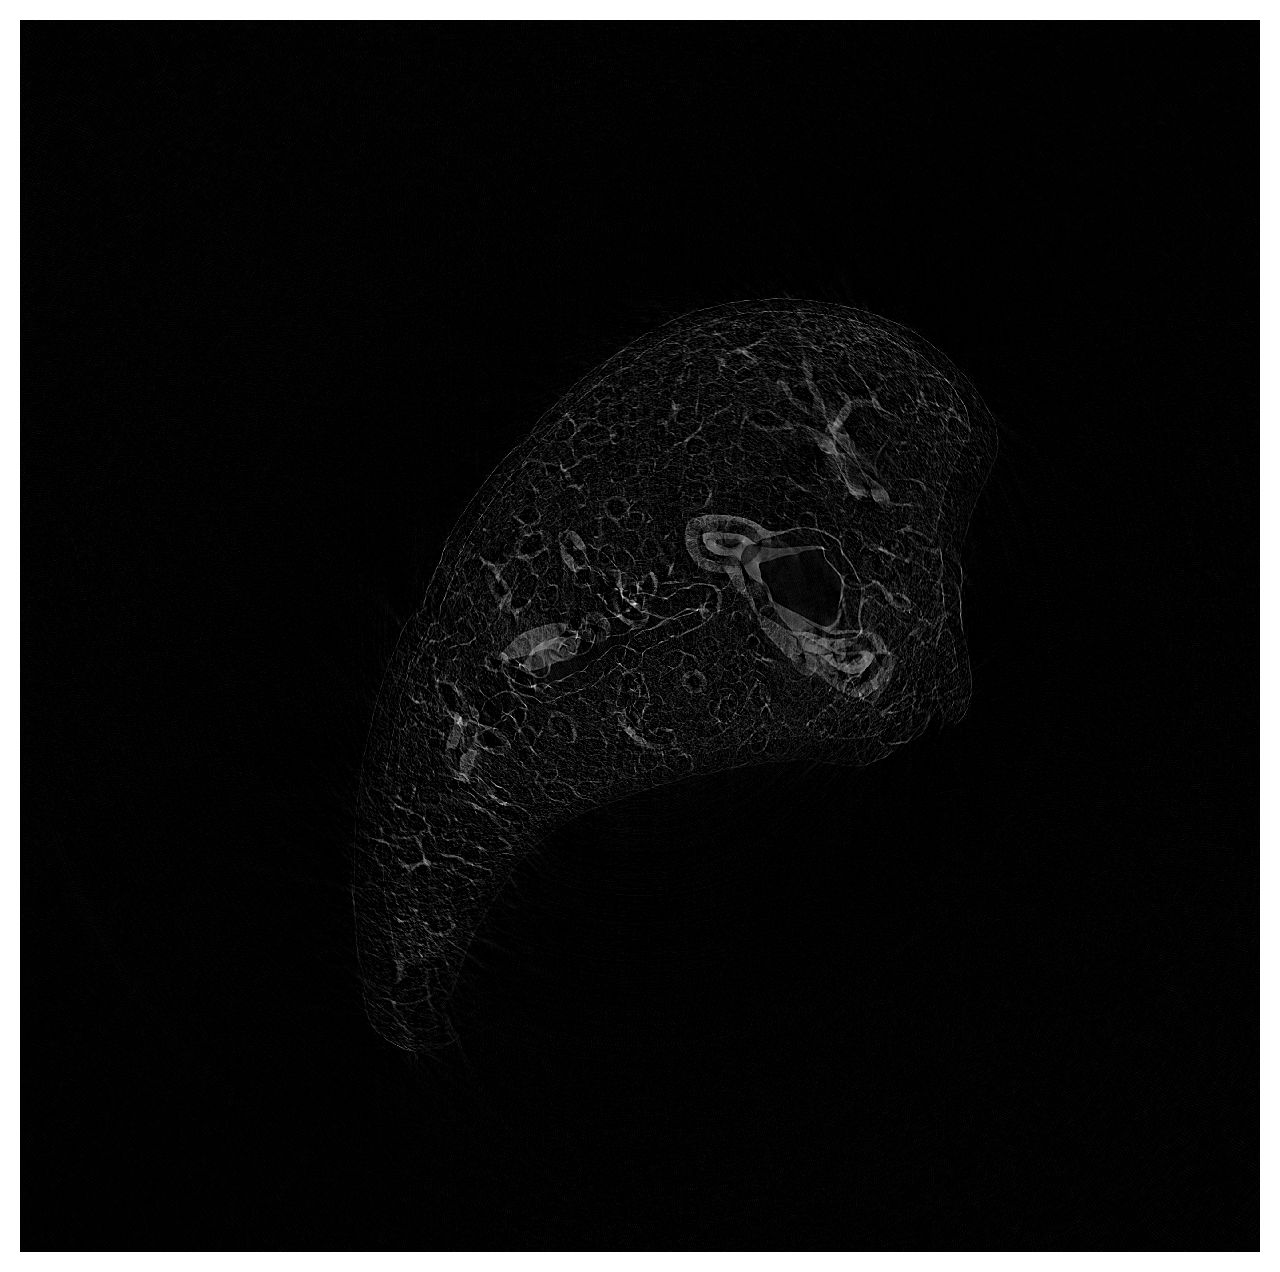

In [243]:
fig, ax = plt.subplots(figsize=(8,8), dpi=200)
ax.imshow(np.flipud(im), cmap=plt.cm.Greys_r, interpolation='nearest', aspect='auto')
ax.axis('off')
plt.show()